In [1]:
import os
import sys
import argparse
import pandas as pd
import torch
import anndata as ad
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from DeepRUOT.losses import OT_loss1
from DeepRUOT.utils import (
    generate_steps, load_and_merge_config,
    SchrodingerBridgeConditionalFlowMatcher,
    generate_state_trajectory, get_batch, get_batch_size
)
from DeepRUOT.train import train_un1_reduce, train_all
from DeepRUOT.models import FNet, scoreNet2
from DeepRUOT.constants import DATA_DIR, RES_DIR
from DeepRUOT.exp import setup_exp

### Convert adata to csv

In [ ]:
import scanpy as sc
# Load your own adata
original_data = sc.read_h5ad('../Weinreb_data.h5ad')
# Assume the data has been preprocessed
# and the dim reduction has been done

# Dim reduction data
X_reduced = original_data.obsm['X_pca']

# Convert time points, note that you need to change your own time key
sample_values = original_data.obs['Time point'].copy()
sample_values = sample_values.apply(lambda x: (x - 2) / 2) # change this according to your own data

n_components = X_reduced.shape[1]
columns = [f'x{i+1}' for i in range(n_components)]

# Create DataFrame
df = pd.DataFrame(
    X_reduced,
    columns=columns
)

# Add Time point column
df.insert(0, 'samples', sample_values.values)

# Save as CSV file for DeepRUOT analysis, and this file should be the same as that in the config file
output_file = '../data/Weinreb_data.csv'
df.to_csv(output_file, index=False)


In [3]:
original_data

AnnData object with n_obs × n_vars = 49302 × 2447
    obs: 'Library', 'Cell barcode', 'Time point', 'Starting population', 'Cell type annotation', 'Well', 'SPRING-x', 'SPRING-y', 'clone', 'batch'
    var: 'gene'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

### Load config

In [4]:
config_path = '../config/weinreb_config.yaml'

# Load and merge configuration
config = load_and_merge_config(config_path)

### Load data and model

In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, config['data']['file_path']))
df = df.iloc[:, :config['data']['dim'] + 1]
device = torch.device('cpu')
exp_dir, logger = setup_exp(
            RES_DIR, 
            config, 
            config['exp']['name']
        )
dim = config['data']['dim']

In [6]:
model_config = config['model']
        
f_net = FNet(
    in_out_dim=model_config['in_out_dim'],
    hidden_dim=model_config['hidden_dim'],
    n_hiddens=model_config['n_hiddens'],
    activation=model_config['activation']
).to(device)

sf2m_score_model = scoreNet2(
    in_out_dim=model_config['in_out_dim'],
    hidden_dim=model_config['score_hidden_dim'],
    activation=model_config['activation']
).float().to(device)

In [7]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir, 'model_final'),map_location=torch.device('cpu')))
f_net.to(device)
sf2m_score_model.load_state_dict(torch.load(os.path.join(exp_dir, 'score_model_final'),map_location=torch.device('cpu')))
sf2m_score_model.to(device)

scoreNet2(
  (activation): LeakyReLU(negative_slope=0.01)
  (net): Sequential(
    (0): Linear(in_features=51, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

### Dim reduction (Optional)

In [8]:
import numpy as np
import joblib
from sklearn.decomposition import PCA  # Import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import umap
# umap_op = PCA(n_components=2)
umap_op = umap.UMAP(n_components=2, random_state=42) # You may change UMAP to PCA or other dimension reduction methods
xu = umap_op.fit_transform(df.iloc[:, 1:])  # Assuming df is your DataFrame
joblib.dump(umap_op, os.path.join(exp_dir, 'dim_reduction.pkl'))  # Save the UMAP model

/lustre/home/2501111653/miniconda3/envs/DeepRUOTv2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


['/lustre/home/2501111653/DeepRUOTv2_test_data/results/weinreb_experiment/dim_reduction.pkl']

### Plot Velocity

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = 'cuda'
f_net.to(device)
sf2m_score_model.to(device)
all_times = df['samples'].values
all_data = df[[f'x{i}' for i in range(1, dim + 1)]].values

t_tensor = torch.tensor(all_times, dtype=torch.float32).unsqueeze(1).to(device)
data_tensor = torch.tensor(all_data, dtype=torch.float32).to(device)

# Calculate velocity of ODE
with torch.no_grad():
    velocity_ode = f_net.v_net(t_tensor, data_tensor)

velocity_ode_np = velocity_ode.cpu().numpy()

data_tensor.requires_grad_(True)  # Enable gradient tracking


# Calculate score
log_density_values = sf2m_score_model(t_tensor, data_tensor)
log_density_values.backward(torch.ones_like(log_density_values))
score = data_tensor.grad
score = score.cpu().numpy()

# Calculate overall drift
drift = velocity_ode_np + score

/lustre/home/2501111653/miniconda3/envs/DeepRUOTv2/lib/python3.10/site-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [10]:
import anndata
import scvelo as scv
import scanpy as sc
import numpy as np

# Assume your data is already defined
# all_data: 50-dimensional data with shape (n_cells, 50)  
# gradients: 50-dimensional vector field with shape (n_cells, 50)
# pca: Trained PCA or UMAP model for generating X_umap
# X_umap: Pre-computed UMAP embeddings with shape (n_cells, 2)

# Create AnnData object
dim_reducer = joblib.load(os.path.join(exp_dir, 'dim_reduction.pkl')) # If no dim reducer is needed, set this to None
adata = anndata.AnnData(X=all_data)

# Set 'Ms' layer to avoid KeyError: 'Ms'
adata.layers['Ms'] = all_data  # Use original 50D data as state matrix

# Set velocity vectors
adata.layers['velocity'] = drift # Store velocity vectors in layers

# Set pre-computed UMAP embeddings
if dim_reducer is not None:
    X_umap = dim_reducer.transform(all_data)  # Assume pca is trained dim reduction model
else:
    X_umap = all_data[:2]
adata.obsm['X_umap'] = X_umap
adata.obs['time'] = all_times
if adata.layers['velocity'].shape[1] != 2:
    # Compute neighbor graph (required for velocity graph)
    sc.pp.neighbors(adata, n_neighbors=30, use_rep='X')  # Calculate neighbors based on high-dim data

    # Compute velocity graph
    scv.tl.velocity_graph(adata, vkey='velocity', n_jobs=16)  # Build velocity graph from high-dim velocity vectors

    # Project velocities to UMAP space
    scv.tl.velocity_embedding(adata, basis='umap', vkey='velocity')  # Project velocities to UMAP
else:
    adata.obsm['velocity_umap'] = adata.layers['velocity']

# Plot
adata.obs['time_categorical'] = pd.Categorical(adata.obs['time'])

# Visualization settings
scv.settings.set_figure_params('scvelo')  # Set scvelo plotting style

computing velocity graph (using 16/64 cores)


  0%|          | 0/49302 [00:00<?, ?cells/s]

    finished (0:00:22) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:07) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


In [11]:
# Optional: load the cell type information

# Need original data to get celltype
original_data = sc.read_h5ad('../Weinreb_data.h5ad')
adata.obs['cell_type'] = original_data.obs['Cell type annotation'].values

# Visualization settings
scv.settings.set_figure_params('scvelo')  # Set scvelo plotting style

saving figure to file /lustre/home/2501111653/DeepRUOTv2_test_data/results/weinreb_experiment/all_velocity_stream_plot.svg


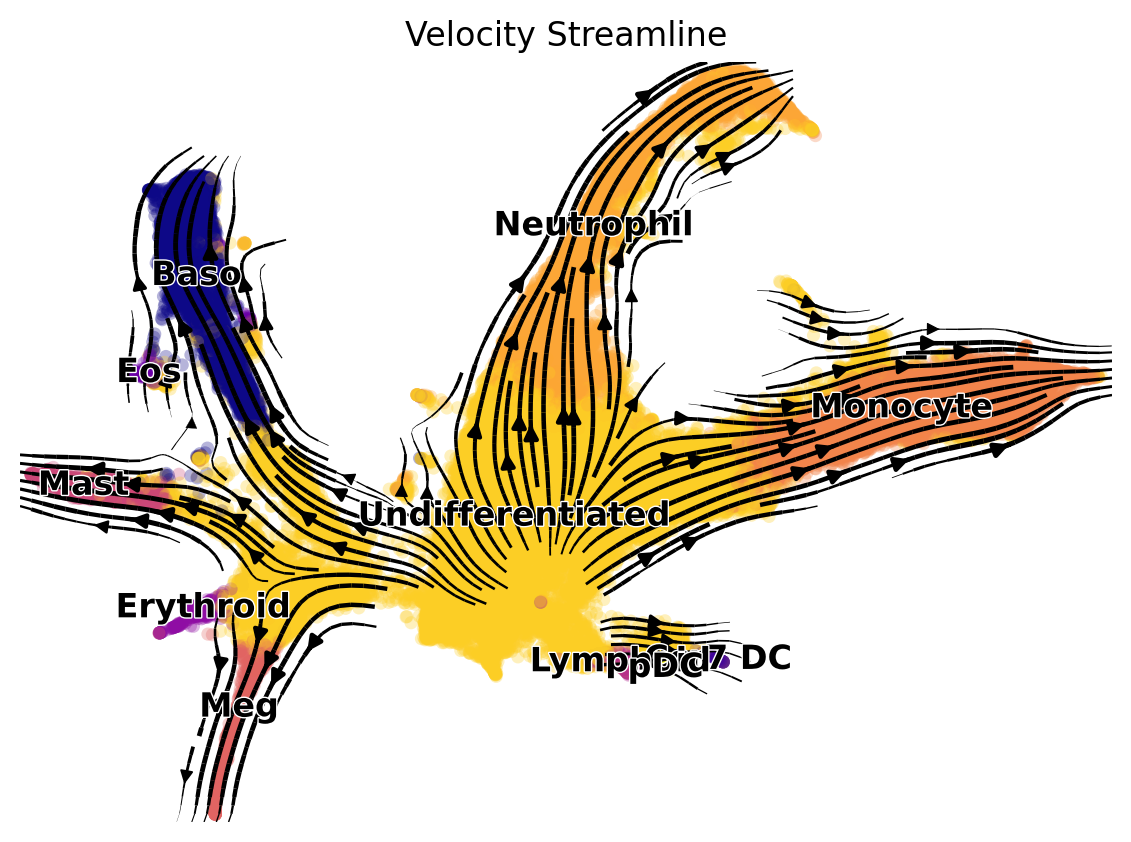

In [12]:
scv.pl.velocity_embedding_stream(
    adata,
    basis='umap',
    color='cell_type',
    figsize=(7, 5),
    density=3,
    title='Velocity Streamline',
    # legend_loc='right',
    palette='plasma',
    save=exp_dir+'/all_velocity_stream_plot.svg'
)

### Fit Potential

In [13]:
# Fit potential on 2D UMAP to create landscape
input = adata.obsm['X_umap']
output = adata.obsm['velocity_umap']
import torch
import torch.nn as nn
import torch.optim as optim

X = torch.tensor(input, dtype=torch.float32)
V = torch.tensor(output.values if hasattr(output, 'values') else output, dtype=torch.float32)

class PotentialNet(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

potential_net = PotentialNet(in_dim=X.shape[1])
potential_net = potential_net.cuda()
X = X.cuda()
V = V.cuda()

optimizer = optim.Adam(potential_net.parameters(), lr=1e-3)
n_epochs = 2000

for epoch in range(n_epochs):
    optimizer.zero_grad()
    X.requires_grad = True
    phi = potential_net(X)
    grad_phi = torch.autograd.grad(
        phi, X, 
        grad_outputs=torch.ones_like(phi), 
        create_graph=True, 
        retain_graph=True, 
        only_inputs=True
    )[0]  # (N, 2)
    # Velocity is the negative gradient of potential
    pred_V = -grad_phi
    loss = ((pred_V - V)**2).mean()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 0.004214
Epoch 50, Loss: 0.000147
Epoch 100, Loss: 0.000109
Epoch 150, Loss: 0.000092
Epoch 200, Loss: 0.000085
Epoch 250, Loss: 0.000082
Epoch 300, Loss: 0.000079
Epoch 350, Loss: 0.000075
Epoch 400, Loss: 0.000073
Epoch 450, Loss: 0.000072
Epoch 500, Loss: 0.000077
Epoch 550, Loss: 0.000078
Epoch 600, Loss: 0.000075
Epoch 650, Loss: 0.000070
Epoch 700, Loss: 0.000071
Epoch 750, Loss: 0.000072
Epoch 800, Loss: 0.000070
Epoch 850, Loss: 0.000072
Epoch 900, Loss: 0.000070
Epoch 950, Loss: 0.000068
Epoch 1000, Loss: 0.000070
Epoch 1050, Loss: 0.000068
Epoch 1100, Loss: 0.000069
Epoch 1150, Loss: 0.000073
Epoch 1200, Loss: 0.000073
Epoch 1250, Loss: 0.000070
Epoch 1300, Loss: 0.000073
Epoch 1350, Loss: 0.000073
Epoch 1400, Loss: 0.000076
Epoch 1450, Loss: 0.000074
Epoch 1500, Loss: 0.000076
Epoch 1550, Loss: 0.000078
Epoch 1600, Loss: 0.000077
Epoch 1650, Loss: 0.000082
Epoch 1700, Loss: 0.000081
Epoch 1750, Loss: 0.000081
Epoch 1800, Loss: 0.000083
Epoch 1850, Loss: 0.0000

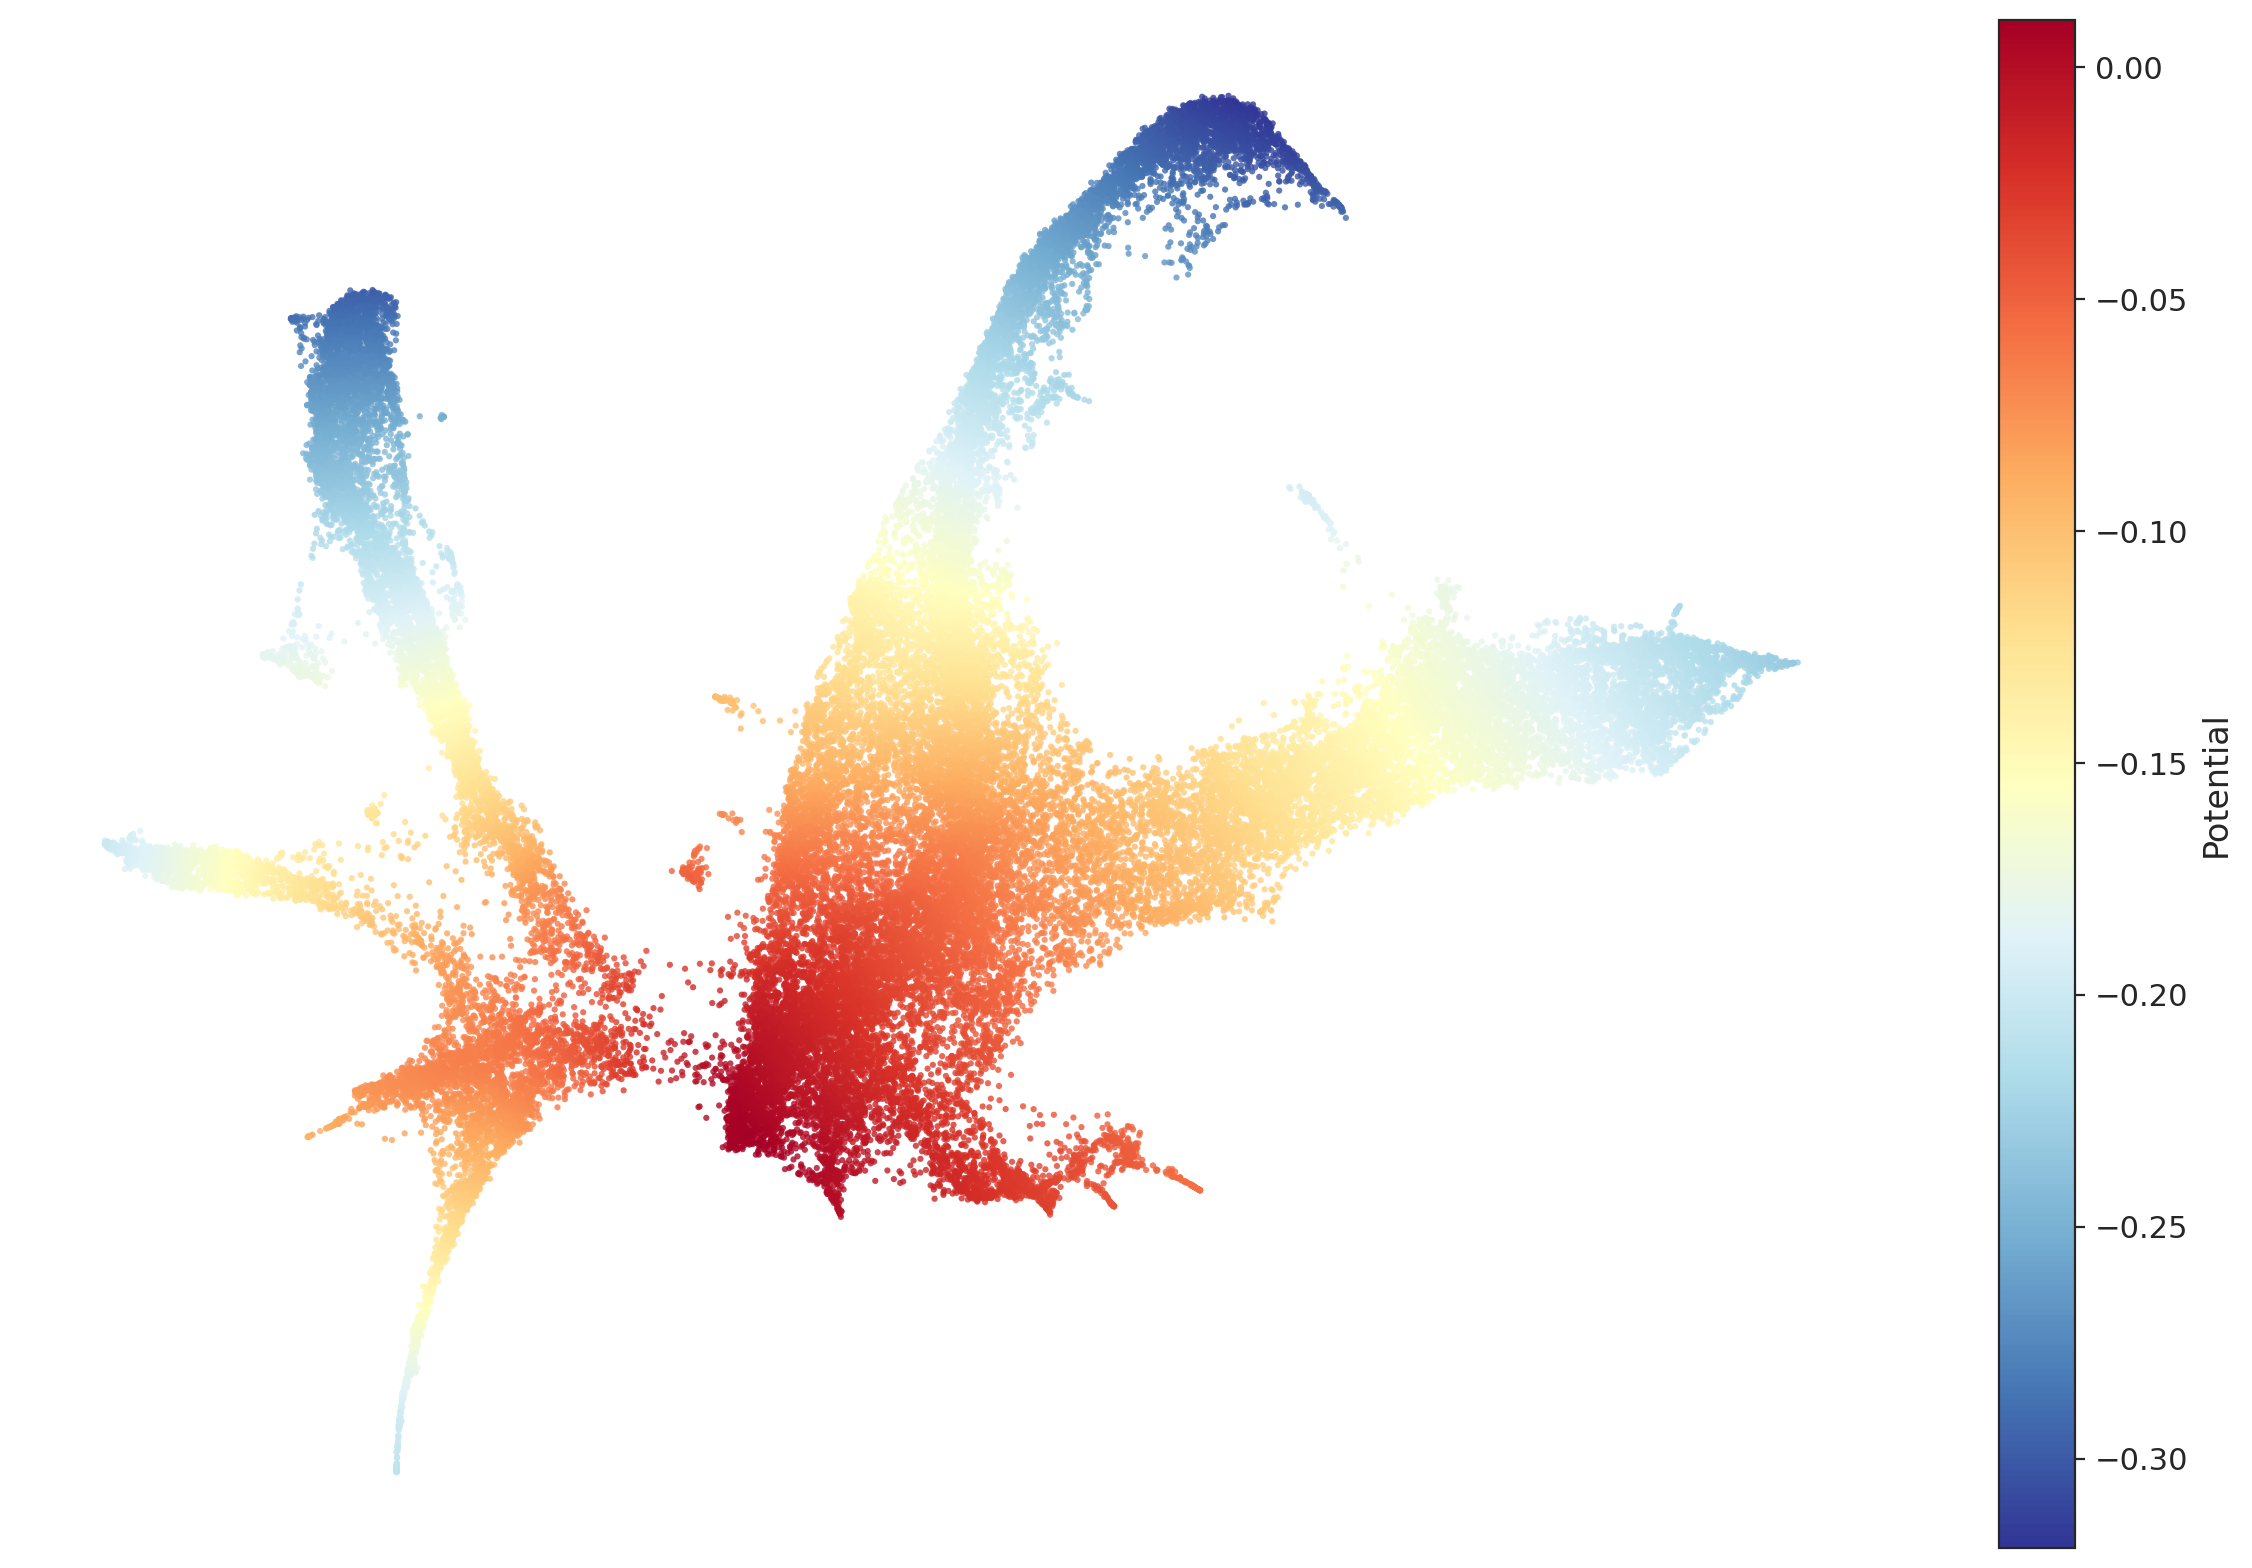

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import torch.nn as nn

device = 'cuda'

# Calculating Potential for original cells
umap_coords = adata.obsm['X_umap']
with torch.no_grad():
    input_tensor = torch.from_numpy(umap_coords).float().to(device)
    original_potentials = potential_net(input_tensor).cpu().numpy().flatten()

# Plot potential
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12, 8))

scatter = sns.scatterplot(
    x=umap_coords[::1, 0],
    y=umap_coords[::1, 1],
    hue=original_potentials[::1],
    palette='RdYlBu_r', 
    s=5,              
    alpha=0.8,           
    edgecolor='none',     
    ax=ax,
    legend=False   
)


norm = plt.Normalize(original_potentials.min(), original_potentials.max())
sm = plt.cm.ScalarMappable(cmap="RdYlBu_r", norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Potential', fontsize=12)


ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_aspect('equal', adjustable='box')
plt.savefig(exp_dir+'/Potential_landscape.png', dpi=300, bbox_inches='tight')
plt.grid(False)

plt.tight_layout()
plt.show()


### Calculate Fate Probability

  0%|          | 0/49302 [00:00<?, ?cell/s]

  0%|          | 0/49302 [00:00<?, ?cell/s]

/lustre/home/2501111653/miniconda3/envs/DeepRUOTv2/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/lustre/home/2501111653/miniconda3/envs/DeepRUOTv2/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/lustre/home/2501111653/miniconda3/envs/DeepRUOTv2/lib/python3.10/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/lustre/home/2501111653/miniconda3/envs/DeepRUOTv2/lib/python3.10/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs

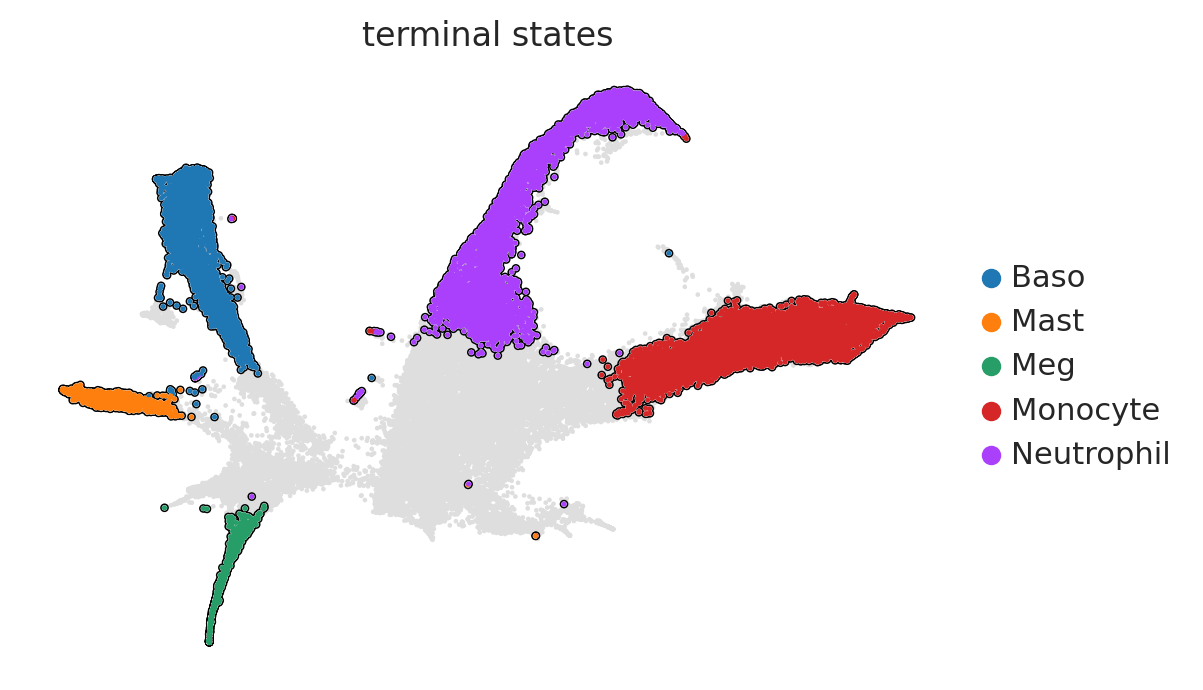

In [15]:
import cellrank as cr
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()

g = cr.estimators.GPCCA(vk)

# Manually define terminal states
manual_terminal_states = {
    "Neutrophil": adata.obs_names[adata.obs["cell_type"] == "Neutrophil"].tolist(),
    "Monocyte": adata.obs_names[adata.obs["cell_type"] == "Monocyte"].tolist(),
    "Meg": adata.obs_names[adata.obs["cell_type"] == "Meg"].tolist(),
    "Mast": adata.obs_names[adata.obs["cell_type"] == "Mast"].tolist(),
    "Baso": adata.obs_names[adata.obs["cell_type"] == "Baso"].tolist(),
}

g.set_terminal_states(manual_terminal_states)

# We can plot to confirm that the terminal states are correctly set
g.plot_macrostates(which="terminal", mode = 'embedding', legend_loc="right margin",)

Defaulting to `'gmres'` solver.


  0%|          | 0/5 [00:00<?, ?/s]

/lustre/home/2501111653/miniconda3/envs/DeepRUOTv2/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/lustre/home/2501111653/miniconda3/envs/DeepRUOTv2/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file /lustre/home/2501111653/DeepRUOTv2_test_data/results/weinreb_experiment/all_fate_probabilities_plot.svg


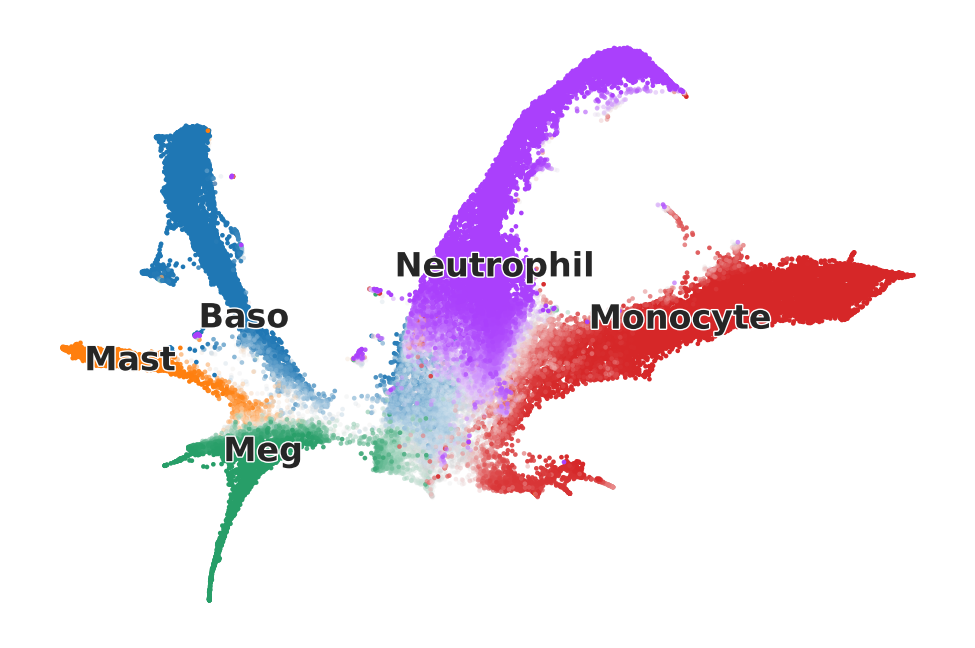

In [16]:
# Calculate fate probabilities
g.compute_fate_probabilities()
g.plot_fate_probabilities(mode="embedding", title = '', save=exp_dir+'/all_fate_probabilities_plot.svg')

### Select transition genes

In [17]:
# Project the velocity back to the gene expression space
pca_components = original_data.varm['PCs'].T
v_ori = drift @ pca_components
top_100_idx = np.argsort(v_ori.mean(axis=0))[-100:][::-1]
# Get the gene names
gene_names = original_data.var['gene'].values[top_100_idx]
print("Transition genes:", gene_names)


Transition genes: ['Psap' 'Ctsb' 'Fth1' 'Ctss' 'Gpnmb' 'Lgals3' 'B2m' 'Lyz2' 'Fabp5' 'Grn'
 'Vim' 'Clec4n' 'Ctsd' 'Anxa4' 'Cd9' 'Itgb2' 'Sirpa' 'Mrc1' 'Mpeg1' 'Lpl'
 'Ahnak' 'Anpep' 'Wfdc17' 'Clec7a' 'Lgmn' 'Fcer1g' 'Gsn' 'Gpr137b' 'Cstb'
 'Laptm5' 'Timp2' 'Mmp12' 'Cd74' 'Atp6v0d2' 'Itm2b' 'Gns' 'H2-Aa' 'Npc2'
 'Lrpap1' 'C3ar1' 'Atp6v0c' 'Sgpl1' 'Myof' 'Plxna1' 'Cd300c2' 'Cd68'
 'Slc6a6' 'Sat1' 'Emp1' 'Rnh1' 'Fabp4' 'Dab2' 'S100a4' 'Cyba' 'Tyrobp'
 'Lilrb4a' 'Lamp1' 'Tnfaip2' 'Ftl1' 'Akr1a1' 'Bnip3l' 'H2-Eb1' 'Cd44'
 'Bri3' 'Anxa5' 'Iqgap1' 'Btg1' 'Lipa' 'Ctla2a' 'Itgam' 'Lasp1' 'Ptms'
 'Klf6' 'Cybb' 'Mcl1' 'Abcg1' 'Lgals3bp' 'Il7r' 'Tapbp' 'Mmp8' 'Gabarap'
 'Plek' 'S100a6' 'Adgre1' 'Cst3' 'Fam198b' 'Clec4a1' 'Clec4d' 'Mpp1'
 'Cndp2' 'Ly6a' 'Plin2' 'Efhd2' 'Actb' 'Rab7b' 'Ctsa' 'Ms4a6d' 'Csf1r'
 'Neat1' 'Cd52']


### Growth Rate Analysis

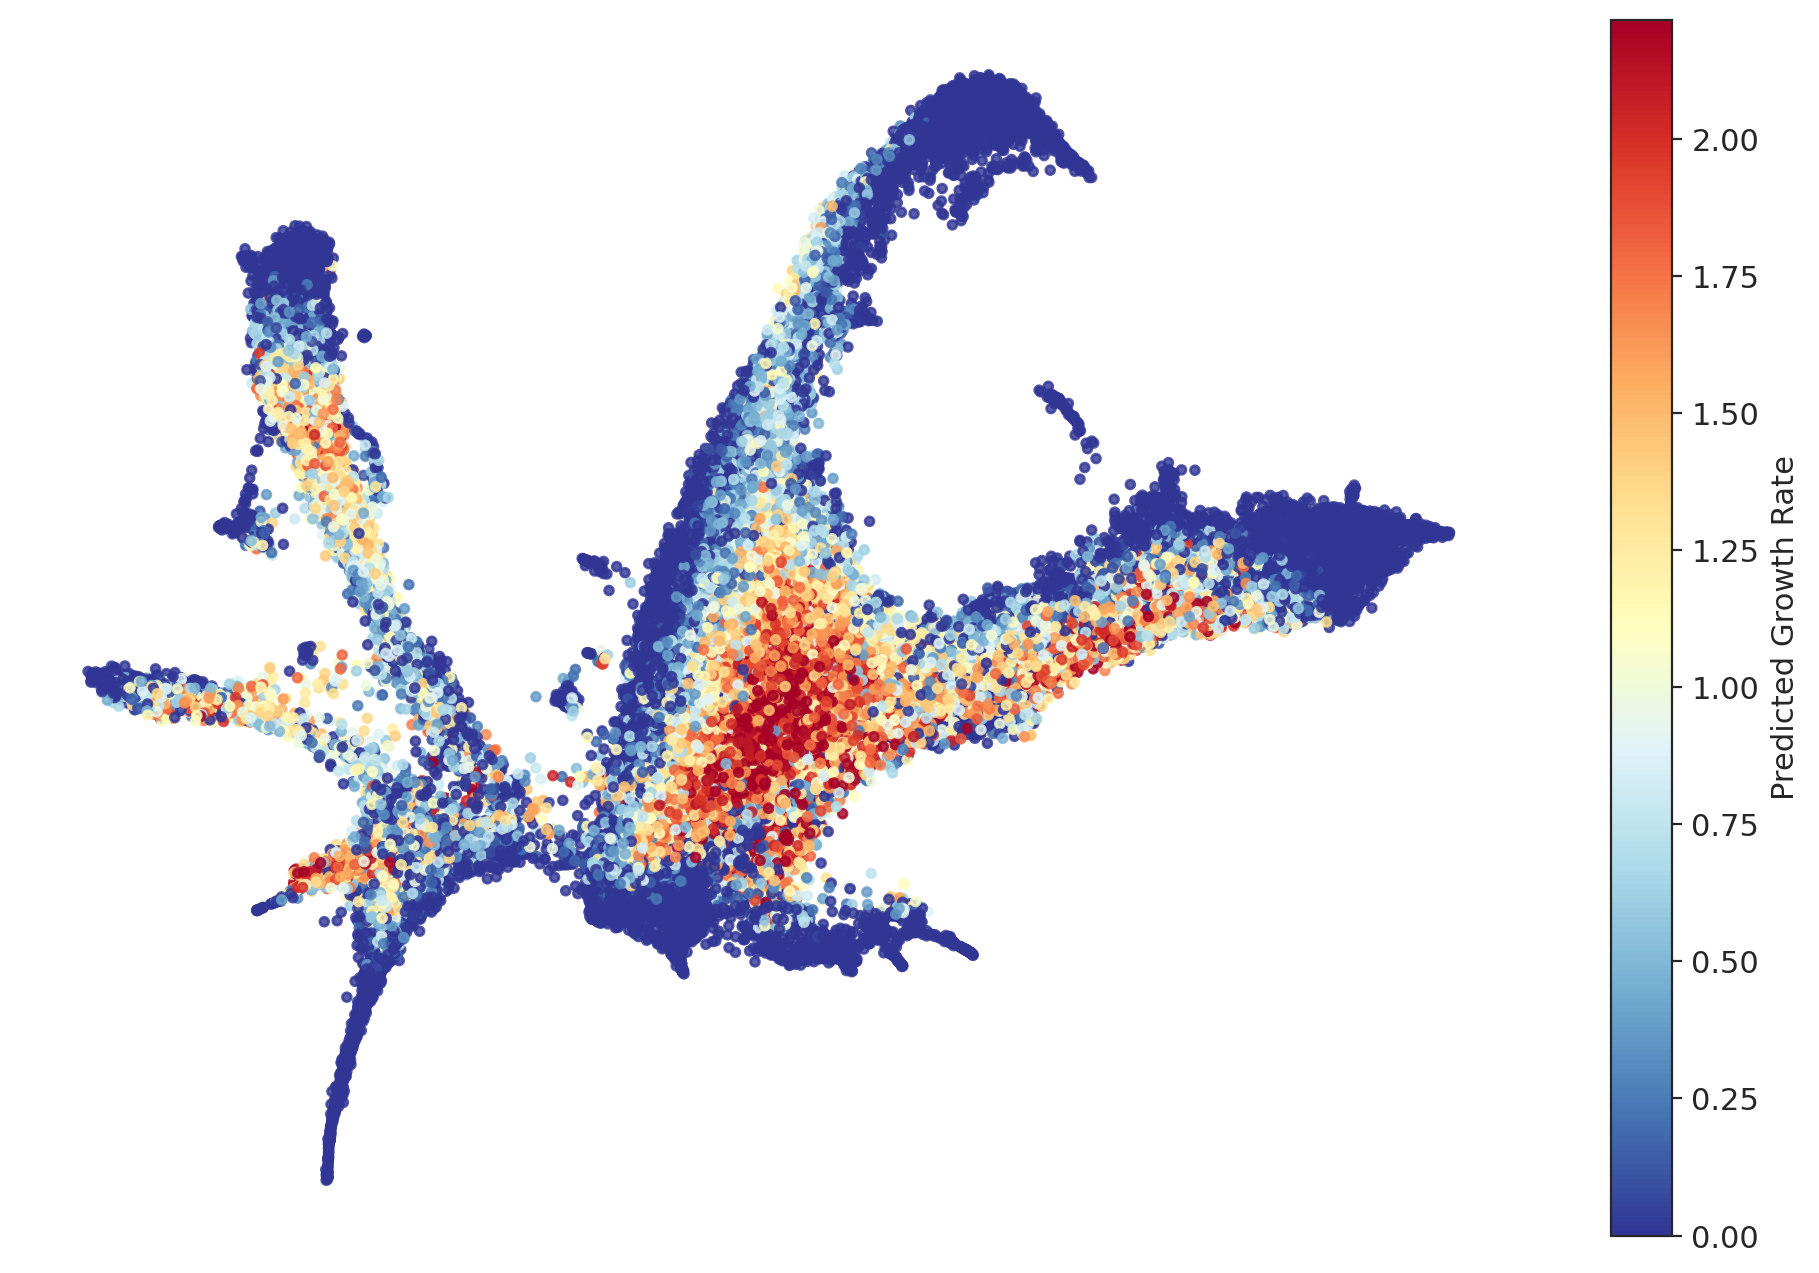

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import joblib

# Load dimension reducer
dim_reducer = joblib.load(os.path.join(exp_dir, 'dim_reduction.pkl')) # If no dim reducer is needed, set this to None
device = 'cpu'
f_net = f_net.to(device)

def plot_g_values(df, f_net, dim_reducer=None, device=device):
    # Get all time points
    time_points = df['samples'].unique()
    
    # Store data for each time point
    data_by_time = {}
    
    # Calculate g_values for each time point
    for time in time_points:
        subset = df[df['samples'] == time]
        n = dim  # Make sure dim is defined

        # Generate column names
        column_names = [f'x{i}' for i in range(1, n + 1)]

        # Convert each column to tensor and move to device
        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        # Stack tensors into 2D tensor
        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g, _, _ = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    # Combine all g_values
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    # Calculate 95th percentile of g_values
    vmax_value = np.percentile(all_g_values, 95)
    
    # Initialize color mapper with clipping
    norm = plt.Normalize(vmin=0, vmax=vmax_value, clip=True)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot data for each time point on same axis
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        n = dim

        column_names = [f'x{i}' for i in range(1, n + 1)]
        new_data = subset[column_names]
        
        if dim_reducer is not None:
            data_reduced = dim_reducer.transform(new_data)
        else:
            data_reduced = new_data.iloc[:, :2].values
            
        x = data_reduced[:, 0]
        y = data_reduced[:, 1]
        
        # Map g_values to colors
        colors = plt.cm.RdYlBu_r(norm(g_values))
        
        # Plot scatter with labels for legend
        ax.scatter(x, y, c=colors, alpha=0.8, marker='o', s=10)
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    # 去掉坐标轴
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # ax.legend()
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Predicted Growth Rate')
    
    # Format colorbar ticks
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{(x):.2f}'))
    
    # Save as PDF
    plt.savefig(os.path.join(exp_dir, 'g_values_plot.svg'), bbox_inches='tight', transparent=True)
    
    plt.show()

# Plot with f_net and df
plot_g_values(df, f_net, dim_reducer=dim_reducer)

In [19]:
# Select growth related genes
g_gradients = []
time_points = df['samples'].unique()
for time in time_points:
    subset = df[df['samples'] == time]
    n = dim

    column_names = [f'x{i}' for i in range(1, n + 1)]

    tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

    data = torch.stack(tensors, dim=1)
    t = torch.tensor([time], dtype=torch.float32).to(device)
    _, g, _, _ = f_net(t, data)
    grad_outputs = torch.ones_like(g)
    g.backward(gradient=grad_outputs)
    # calculate gradients of growth
    g_grad = data.grad.detach().cpu().numpy()
    g_gradients.append(g_grad)

g_gradients_np = np.concatenate(g_gradients, axis=0)

In [20]:
pca_components = original_data.varm['PCs'].T
g_ori = g_gradients_np @ pca_components
top_100_idx = np.argsort(g_ori.mean(axis=0))[-100:][::-1]
# Get the gene names
gene_names = original_data.var['gene'].values[top_100_idx]
print("Growth related genes:", gene_names)


Growth related genes: ['Rps27rt' 'Prss34' 'Rab33b' 'Als2' 'Cdh1' 'Golga3' 'Gm5483' 'BC100530'
 'Mcpt8' 'Crip1' 'Calr' 'Siglech' 'Lgals1' 'Akr1c18' 'Atp1b1' 'Tmed3'
 'Gm37214' 'Fry' 'Stfa3' 'Stfa2' 'Rpl15' 'Igfbp7' 'Dok2' 'Mboat1' 'Ms4a2'
 'Alox5' '2810403D21Rik' 'Ehd3' 'Rap1b' 'Pth1r' 'Hsp90b1' 'Hspa5'
 'Gm26721' 'Gm15402' '4930589L23Rik' 'Gnmt' 'Tgfbi' 'Slc14a1' 'Ubac2'
 'Zfp184' 'Hao1' 'Igsf8' '2010005H15Rik' 'Slc35d3' 'Muc20' 'Havcr1'
 'Slc4a1' 'Alox15' 'Cnrip1' 'Gpr4' 'Serpinb1a' 'P2ry14' 'Gm13709' 'Atoh8'
 'Ly86' 'Prdx1' 'Rab25' 'Perp' 'Hmgn3' 'Ptger3' 'Slc7a8' 'Pltp' 'Arc'
 'Gm11335' 'Mafb' 'Inpp4b' 'Vcl' 'Serpine2' 'Fam178b' 'Cyp4f18' 'Cyp11a1'
 'Hba-a2' 'Fcrla' 'Pdlim4' 'P2ry1' 'Tbxa2r' 'Epx' 'Clec4a3' 'Blnk' 'Prg2'
 'Anxa6' 'Padi2' 'Slc6a9' 'Timp3' 'Cldn11' 'Rsad1' 'Cebpe' 'Gata2' 'Itgb7'
 'D13Ertd608e' 'Rbpms2' 'Gm5416' 'Alas2' 'Klf5' 'Sucnr1' 'Prg3' 'P2ry10'
 'Spint1' 'Dhrs9' 'Akr1c13']


### Interpolation

In [21]:
from DeepRUOT.utils import euler_sdeint
import random
import joblib
import numpy as np
device = 'cuda'
f_net.to(device)
sf2m_score_model.to(device)
all_times = df['samples'].values
n_times = all_times.max() + 1
data=torch.tensor(df[df['samples']==0].values,dtype=torch.float32).requires_grad_()
data_t0 = data[:, 1:].to(device).requires_grad_()
print(data_t0.shape)
x0=data_t0.to(device)

dim_reducer = joblib.load(os.path.join(exp_dir, 'dim_reduction.pkl'))

class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, g, score, input_size=(3, 32, 32), sigma=1.0):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.input_size = input_size
        self.sigma = sigma
        self.g_net = g

    # Drift
    def f(self, t, y):
        z, lnw = y
        drift=self.drift(t, z)
        dlnw = self.g_net(t, z)
        num = z.shape[0]
        t = t.expand(num, 1)  # Keep gradient information of t and expand its shape
        return (drift+self.score.compute_gradient(t, z), dlnw)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y)*self.sigma
    
x0_subset = x0.to(device)

x0_subset = x0_subset.to(device)
lnw0 = torch.log(torch.ones(x0_subset.shape[0], 1) / x0_subset.shape[0]).to(device)
initial_state = (x0_subset, lnw0)

# Define SDE object
sde = SDE(f_net.v_net, 
          f_net.g_net, 
          sf2m_score_model, 
          input_size=(2,), 
          sigma=config['score_train']['sigma'])


ts_points = torch.tensor([0.0, 0.5, 1.0], dtype=torch.float32)  # 0.5 is the unseen timepoint
print(ts_points)

sde_point, traj_lnw = euler_sdeint(sde, initial_state, dt=0.1, ts=ts_points)
print(sde_point.shape)
print(traj_lnw.shape)
weight = torch.exp(traj_lnw)
weight_normed = weight/weight.sum(dim = 1, keepdim = True)

sde_point_np = sde_point.detach().cpu().numpy()
sde_point_list = sde_point_np.tolist()
sde_point_array = np.array(sde_point_list, dtype=object)

torch.Size([4638, 50])
tensor([0.0000, 0.5000, 1.0000])
torch.Size([3, 4638, 50])
torch.Size([3, 4638, 1])


In [23]:
df_new = pd.read_csv(os.path.join(DATA_DIR, config['data']['file_path']))
cell_type = original_data.obs['Cell type annotation'].values
all_labels = pd.Categorical(cell_type)
df_new['Annotation'] = all_labels
df_new

,samples,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x42,x43,x44,x45,x46,x47,x48,x49,x50,Annotation
0,0,-1.217456,-1.876922,-1.205544,-2.138494,-2.375819,-1.729328,0.651229,-0.338510,0.041160,...,0.054111,0.278638,0.218402,1.900351,0.188479,-0.624556,-0.143188,0.780808,-0.624784,Undifferentiated
1,0,-5.243580,-1.761129,-1.729367,-1.019093,0.175251,0.097280,-0.423565,-0.407035,-2.576229,...,-0.024745,0.428439,0.536177,0.373199,-0.229468,0.097612,-0.208186,0.435171,0.263994,Undifferentiated
2,0,-5.752447,-1.419319,-2.102163,-0.605931,0.029611,0.116759,-0.268277,-0.513728,-0.409831,...,0.045515,0.171796,0.163721,0.497674,-0.512460,0.028188,-0.160119,0.131542,0.413676,Undifferentiated
3,0,-4.255497,-2.384707,-0.330012,-1.585662,-2.652925,0.520510,0.198466,-1.104815,-0.800885,...,0.311630,-0.553470,-0.514273,0.416959,0.150009,0.026914,0.030274,0.200624,0.081662,Undifferentiated
4,0,-4.877692,0.824647,0.232769,2.845089,-1.172621,-0.222511,0.250738,-0.406565,-0.113559,...,0.059187,0.898496,-0.194554,0.430735,0.015443,-0.698956,1.154398,-0.912015,-0.101607,Undifferentiated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49297,2,-7.065715,2.007633,0.619574,3.793502,-1.925619,2.546932,0.242512,0.905567,1.139781,...,-0.090863,0.651469,0.029022,0.714116,-1.062683,-0.118945,0.358995,0.626652,-0.648994,Undifferentiated
49298,2,-5.770710,-1.731957,-0.978848,-1.203649,-2.223124,0.994655,-0.472510,-0.973434,0.074024,...,0.207697,-0.309746,-0.290887,-0.561833,-0.185721,-0.286728,0.138851,0.289373,-0.958307,Undifferentiated
49299,2,0.250359,-2.772287,1.352441,-2.562624,-2.185664,-2.237595,1.094841,-0.884417,0.565153,...,0.173202,-0.346234,0.683077,0.718787,-0.206094,0.077363,-0.306639,-0.567678,0.629165,Neutrophil
49300,2,12.654426,0.758303,-6.569150,-1.810055,-3.827207,-6.287392,2.184073,4.394424,-1.419851,...,-1.361348,0.553498,0.251884,-0.941483,-0.814592,-0.282054,0.654892,-0.863675,-0.089109,Monocyte


In [24]:
# Cell annotation
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

X = df_new.iloc[:,:-1].values
y = df_new['Annotation'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Classifier
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.LeakyReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

input_size = 51
hidden_size = 128 
num_classes = len(label_encoder.classes_) 
model = MLP(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
num_epochs = 10000
model = model.cuda()
X_train = X_train.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    model.train()
    X_train.requires_grad_(True)
    outputs = model(X_train)
    loss = criterion(outputs, y_train.cuda())
    grad_outputs = torch.ones_like(outputs)
    grads = torch.autograd.grad(
        outputs=outputs,
        inputs=X_train,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    grad_dim1 = grads[:, 0]
    grad_norm = grad_dim1.abs().mean()
    reg_lambda = 1e-2
    weight_decay = 1e-4
    l2_reg = torch.tensor(0., device=loss.device)
    for param in model.parameters():
        if param.requires_grad:
            l2_reg = l2_reg + torch.norm(param, 2) ** 2
    loss = loss + reg_lambda * grad_norm + weight_decay * l2_reg
    X_train.requires_grad_(False)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        # 步骤 4：评估模型
        model.eval()  # 设置为评估模式
        with torch.no_grad():
            outputs = model(X_test.cuda())
            _, predicted = torch.max(outputs, 1)  # 获取预测类别
            accuracy = accuracy_score(y_test, predicted.cpu())
            print(f'Acc: {accuracy:.4f}')

Epoch [100/10000], Loss: 0.1152
Acc: 0.9595
Epoch [200/10000], Loss: 0.0873
Acc: 0.9662
Epoch [300/10000], Loss: 0.0746
Acc: 0.9686
Epoch [400/10000], Loss: 0.0660
Acc: 0.9692
Epoch [500/10000], Loss: 0.0592
Acc: 0.9694
Epoch [600/10000], Loss: 0.0534
Acc: 0.9694
Epoch [700/10000], Loss: 0.0484
Acc: 0.9693
Epoch [800/10000], Loss: 0.0440
Acc: 0.9691
Epoch [900/10000], Loss: 0.0401
Acc: 0.9685
Epoch [1000/10000], Loss: 0.0367
Acc: 0.9682
Epoch [1100/10000], Loss: 0.0339
Acc: 0.9686
Epoch [1200/10000], Loss: 0.0318
Acc: 0.9684
Epoch [1300/10000], Loss: 0.0301
Acc: 0.9675
Epoch [1400/10000], Loss: 0.0287
Acc: 0.9674
Epoch [1500/10000], Loss: 0.0276
Acc: 0.9668
Epoch [1600/10000], Loss: 0.0265
Acc: 0.9669
Epoch [1700/10000], Loss: 0.0257
Acc: 0.9666
Epoch [1800/10000], Loss: 0.0250
Acc: 0.9663
Epoch [1900/10000], Loss: 0.0243
Acc: 0.9668
Epoch [2000/10000], Loss: 0.0237
Acc: 0.9665
Epoch [2100/10000], Loss: 0.0233
Acc: 0.9677
Epoch [2200/10000], Loss: 0.0228
Acc: 0.9674
Epoch [2300/10000],

In [26]:
# Predict Cell type
torch.save(model.state_dict(), exp_dir + '/mlp_classifier.pth')
model.eval()
model.to('cuda')
predicted_labels_list = []

ts = torch.tensor([0.0, 0.5, 1.0], dtype=torch.float32)
predicted_labels_list.append(df_new[df_new['samples']==0]['Annotation'].values)

for i in range(1, len(sde_point)):
    t = ts[i]
    traj_t = np.array(sde_point[i].detach().cpu().numpy(), dtype = np.float64)
    traj_t = torch.tensor(traj_t)
    n_samples = traj_t.shape[0]
    
    samples_t = t * torch.ones((n_samples, 1))
    input_t = torch.cat((samples_t, traj_t), dim=1)
    
    with torch.no_grad():
        outputs = model(input_t.float().cuda())
        _, predicted = torch.max(outputs, 1)
        predicted_labels = label_encoder.inverse_transform(predicted.detach().cpu().numpy())
    
    predicted_labels_list.append(predicted_labels)


import matplotlib

cmap = matplotlib.cm.get_cmap('tab20')

all_labels = np.unique(np.concatenate(predicted_labels_list))
label_to_int = {label: idx for idx, label in enumerate(all_labels)}

predicted_colors_list = []
for labels in predicted_labels_list:
    label_indices = np.array([label_to_int[label] for label in labels])
    colors = cmap(label_indices % cmap.N)
    predicted_colors_list.append(colors)

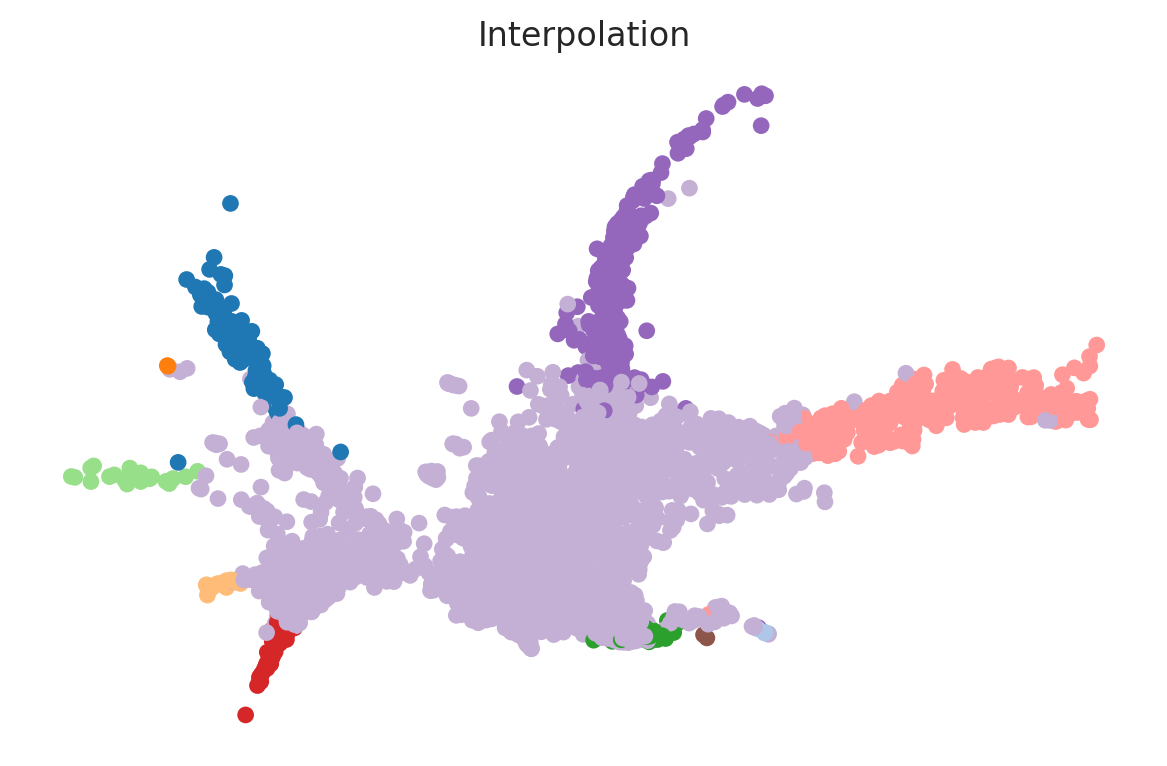

In [27]:
# Plot interpolation data
data_slice = sde_point[1]
data_plot = data_slice.detach().cpu().numpy()
data_plot_reduced = dim_reducer.transform(data_plot)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(data_plot_reduced[:, 0], data_plot_reduced[:, 1], c=predicted_colors_list[1], alpha=1.0, s=25)
ax.set_axis_off()
ax.set_title('Interpolation')
plt.tight_layout()
plt.show()

### GRN

PCA model loaded, number of original genes = 2447


Processing time points:   0%|          | 0/3 [00:00<?, ?it/s]

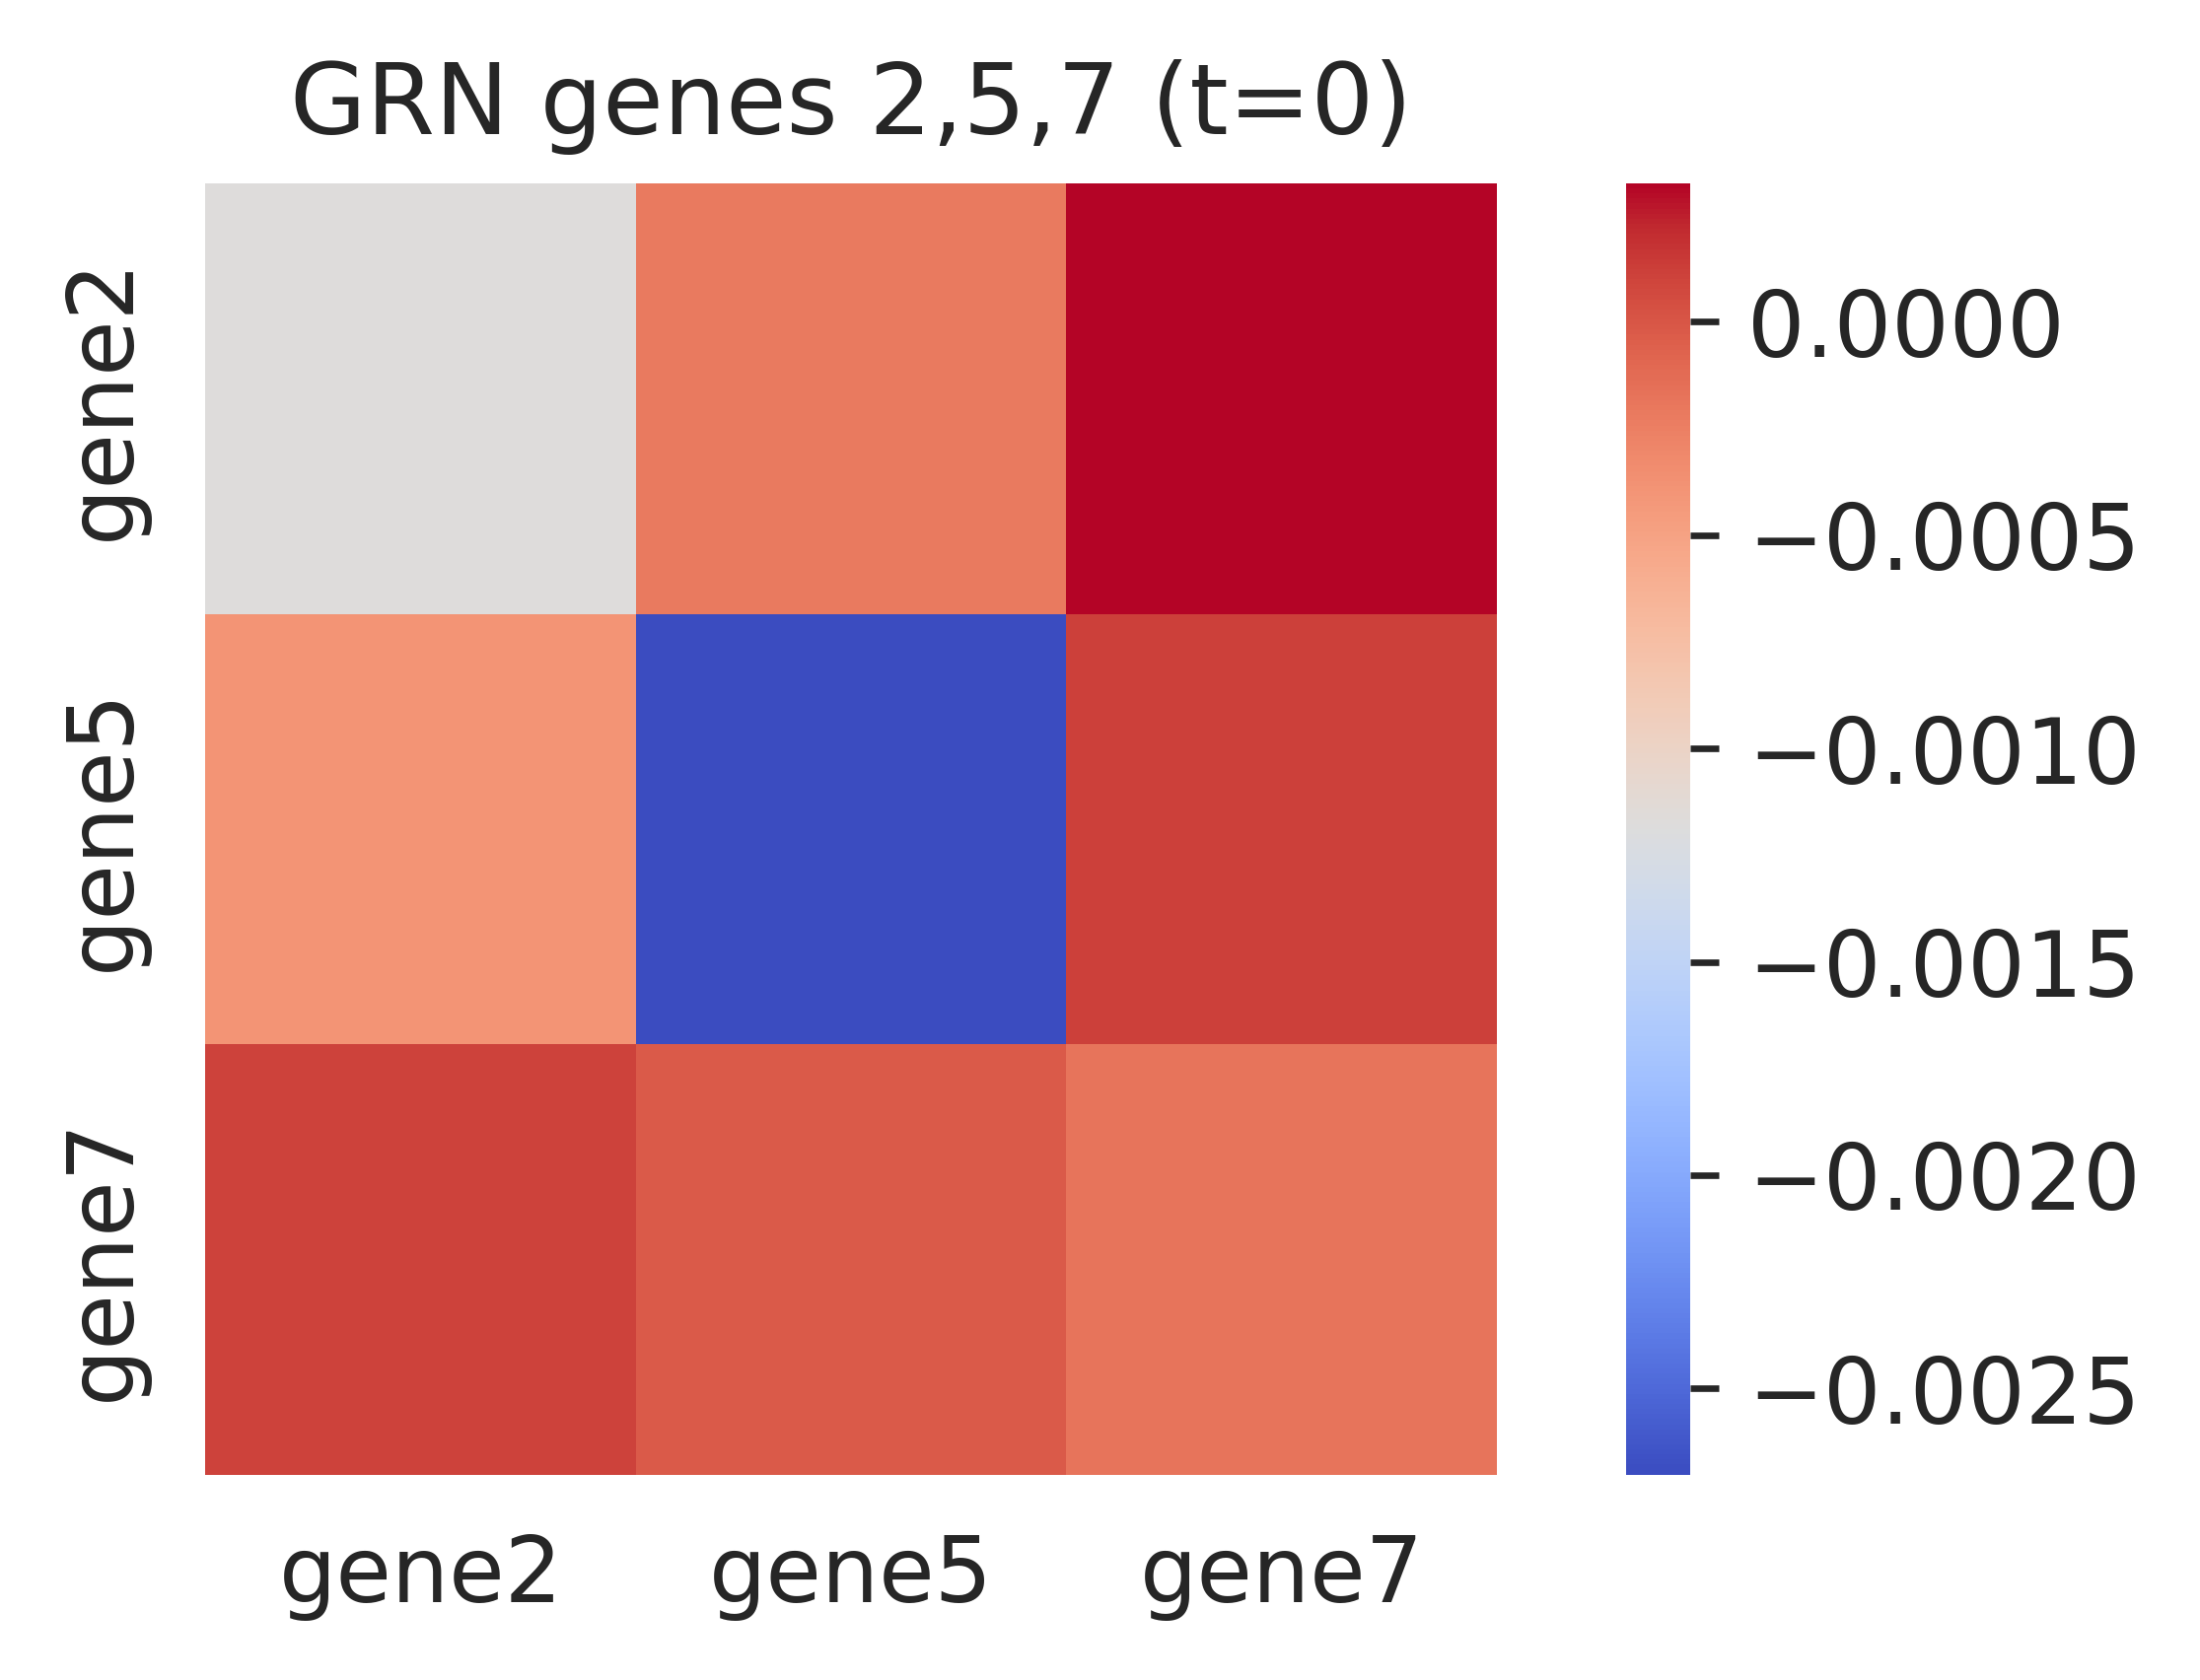

Processing time points:  33%|███▎      | 1/3 [00:01<00:02,  1.43s/it]

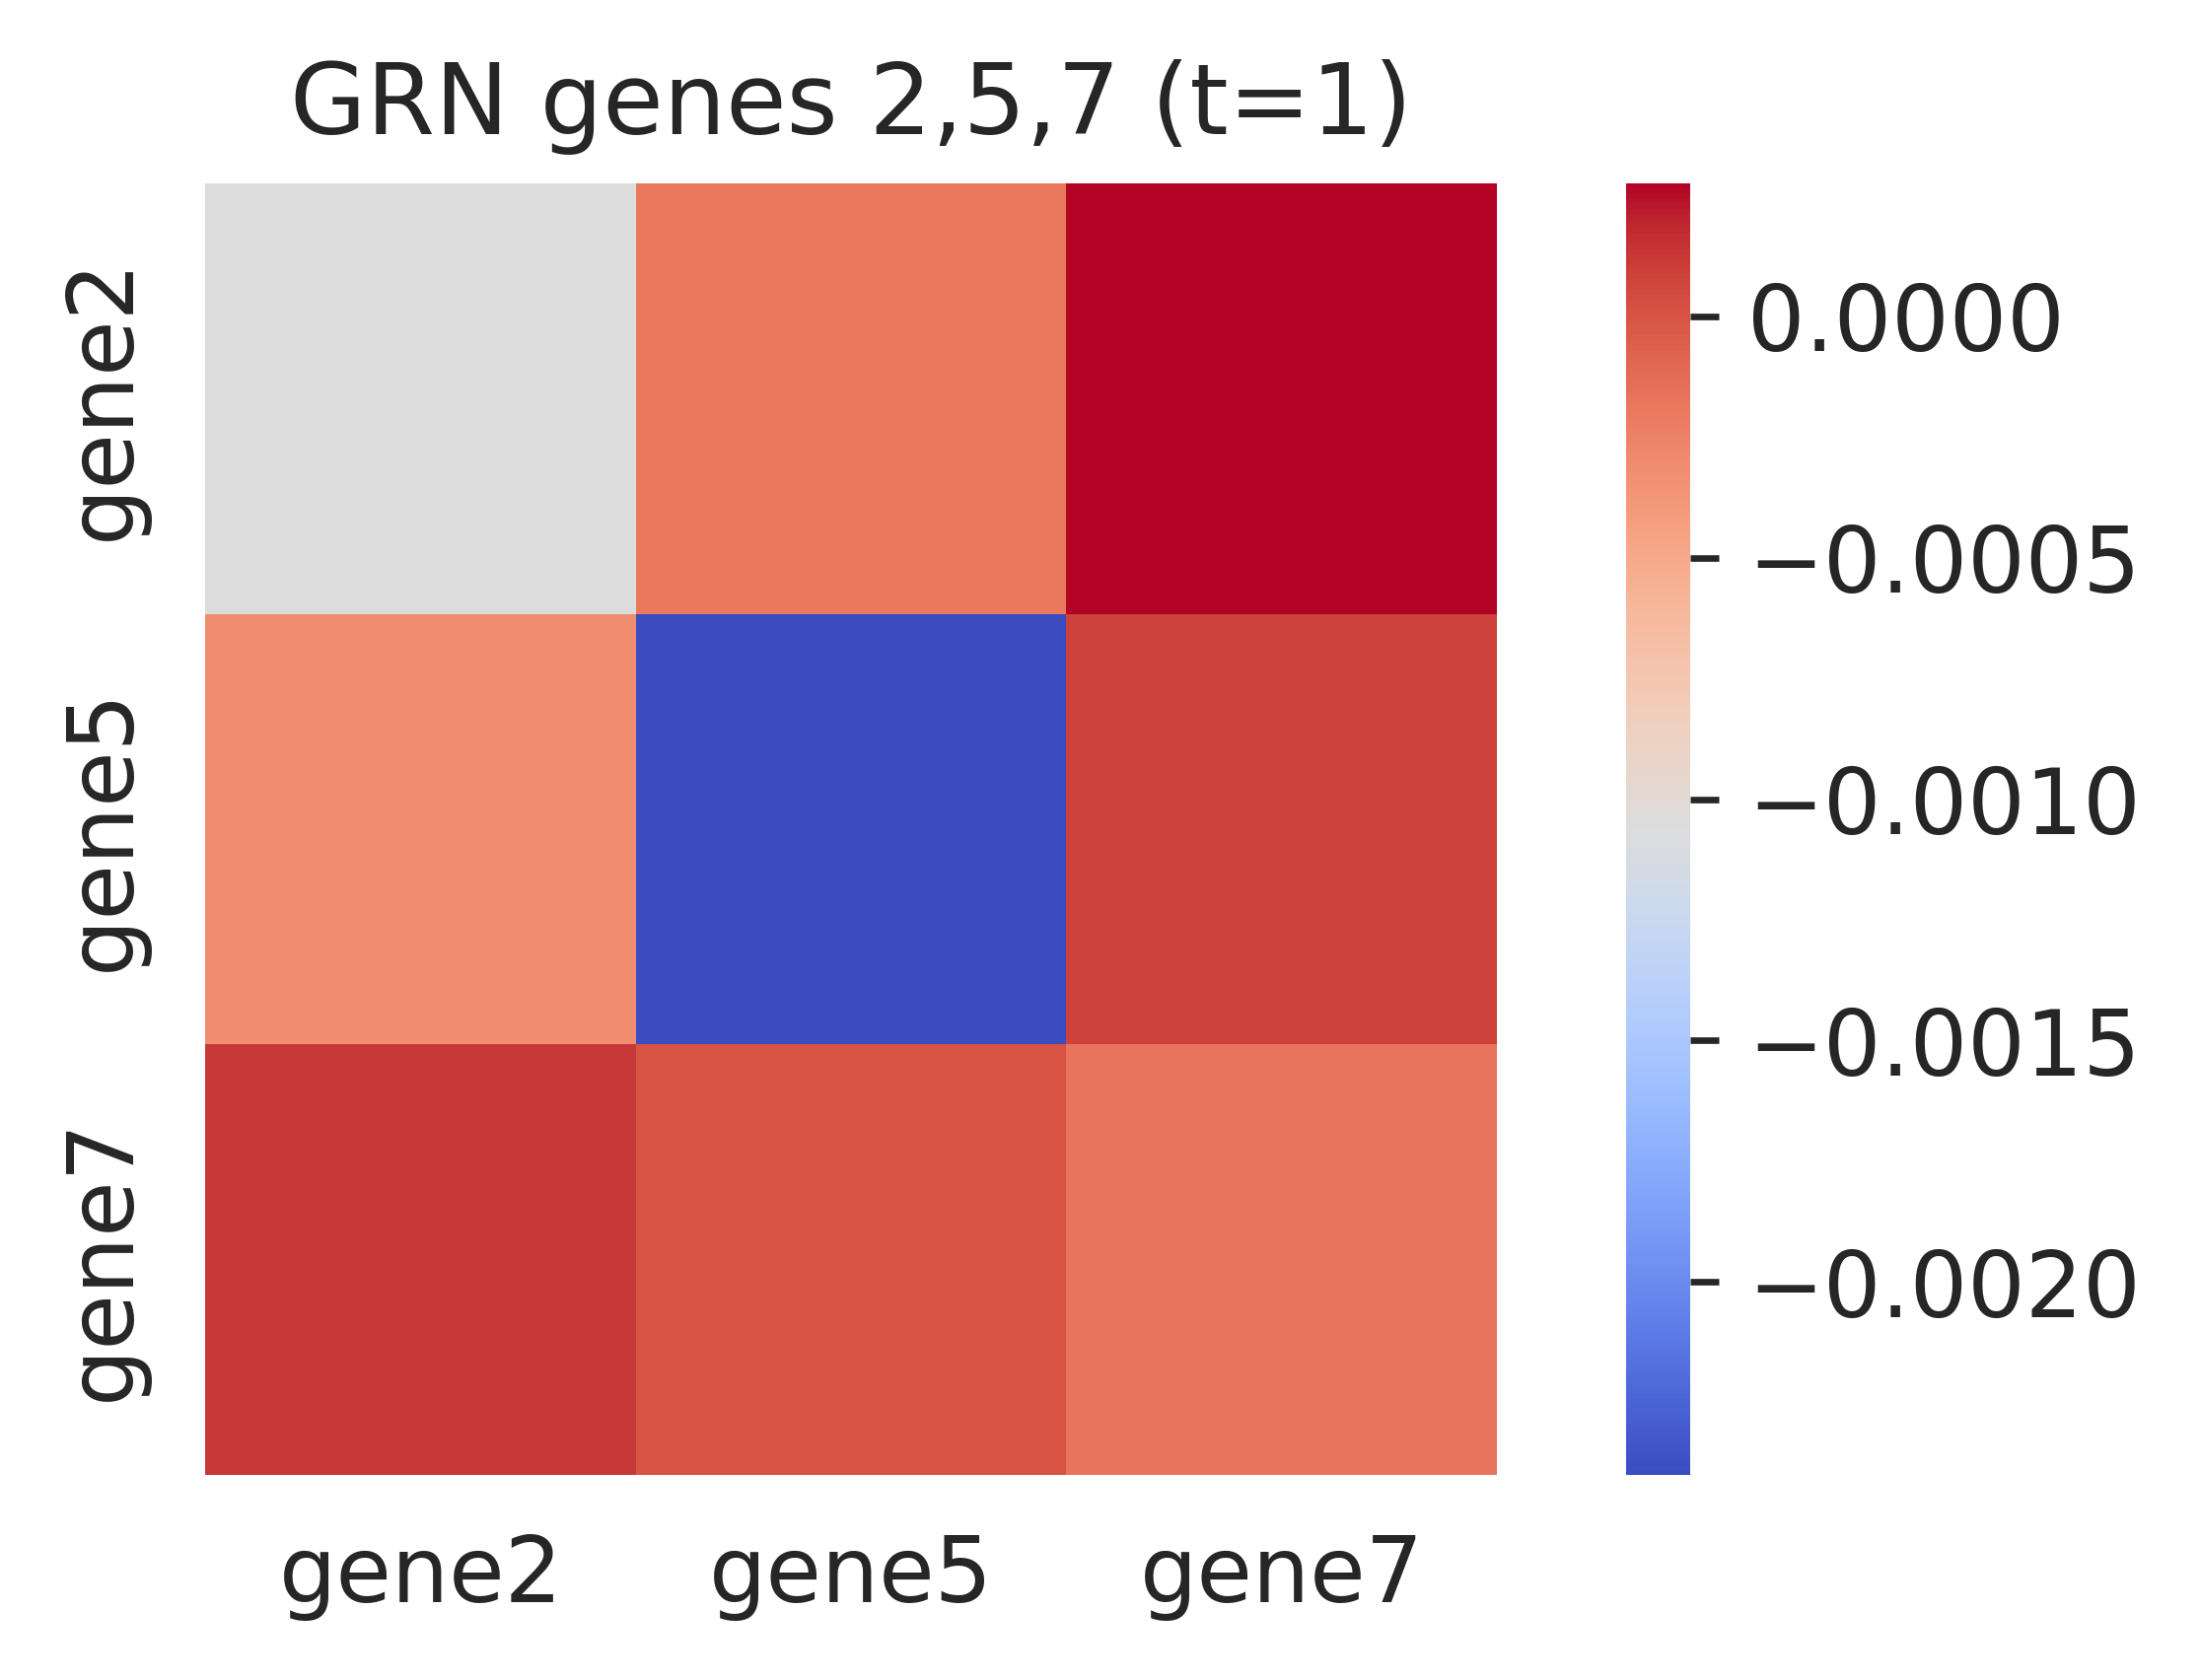

Processing time points:  67%|██████▋   | 2/3 [00:02<00:01,  1.41s/it]

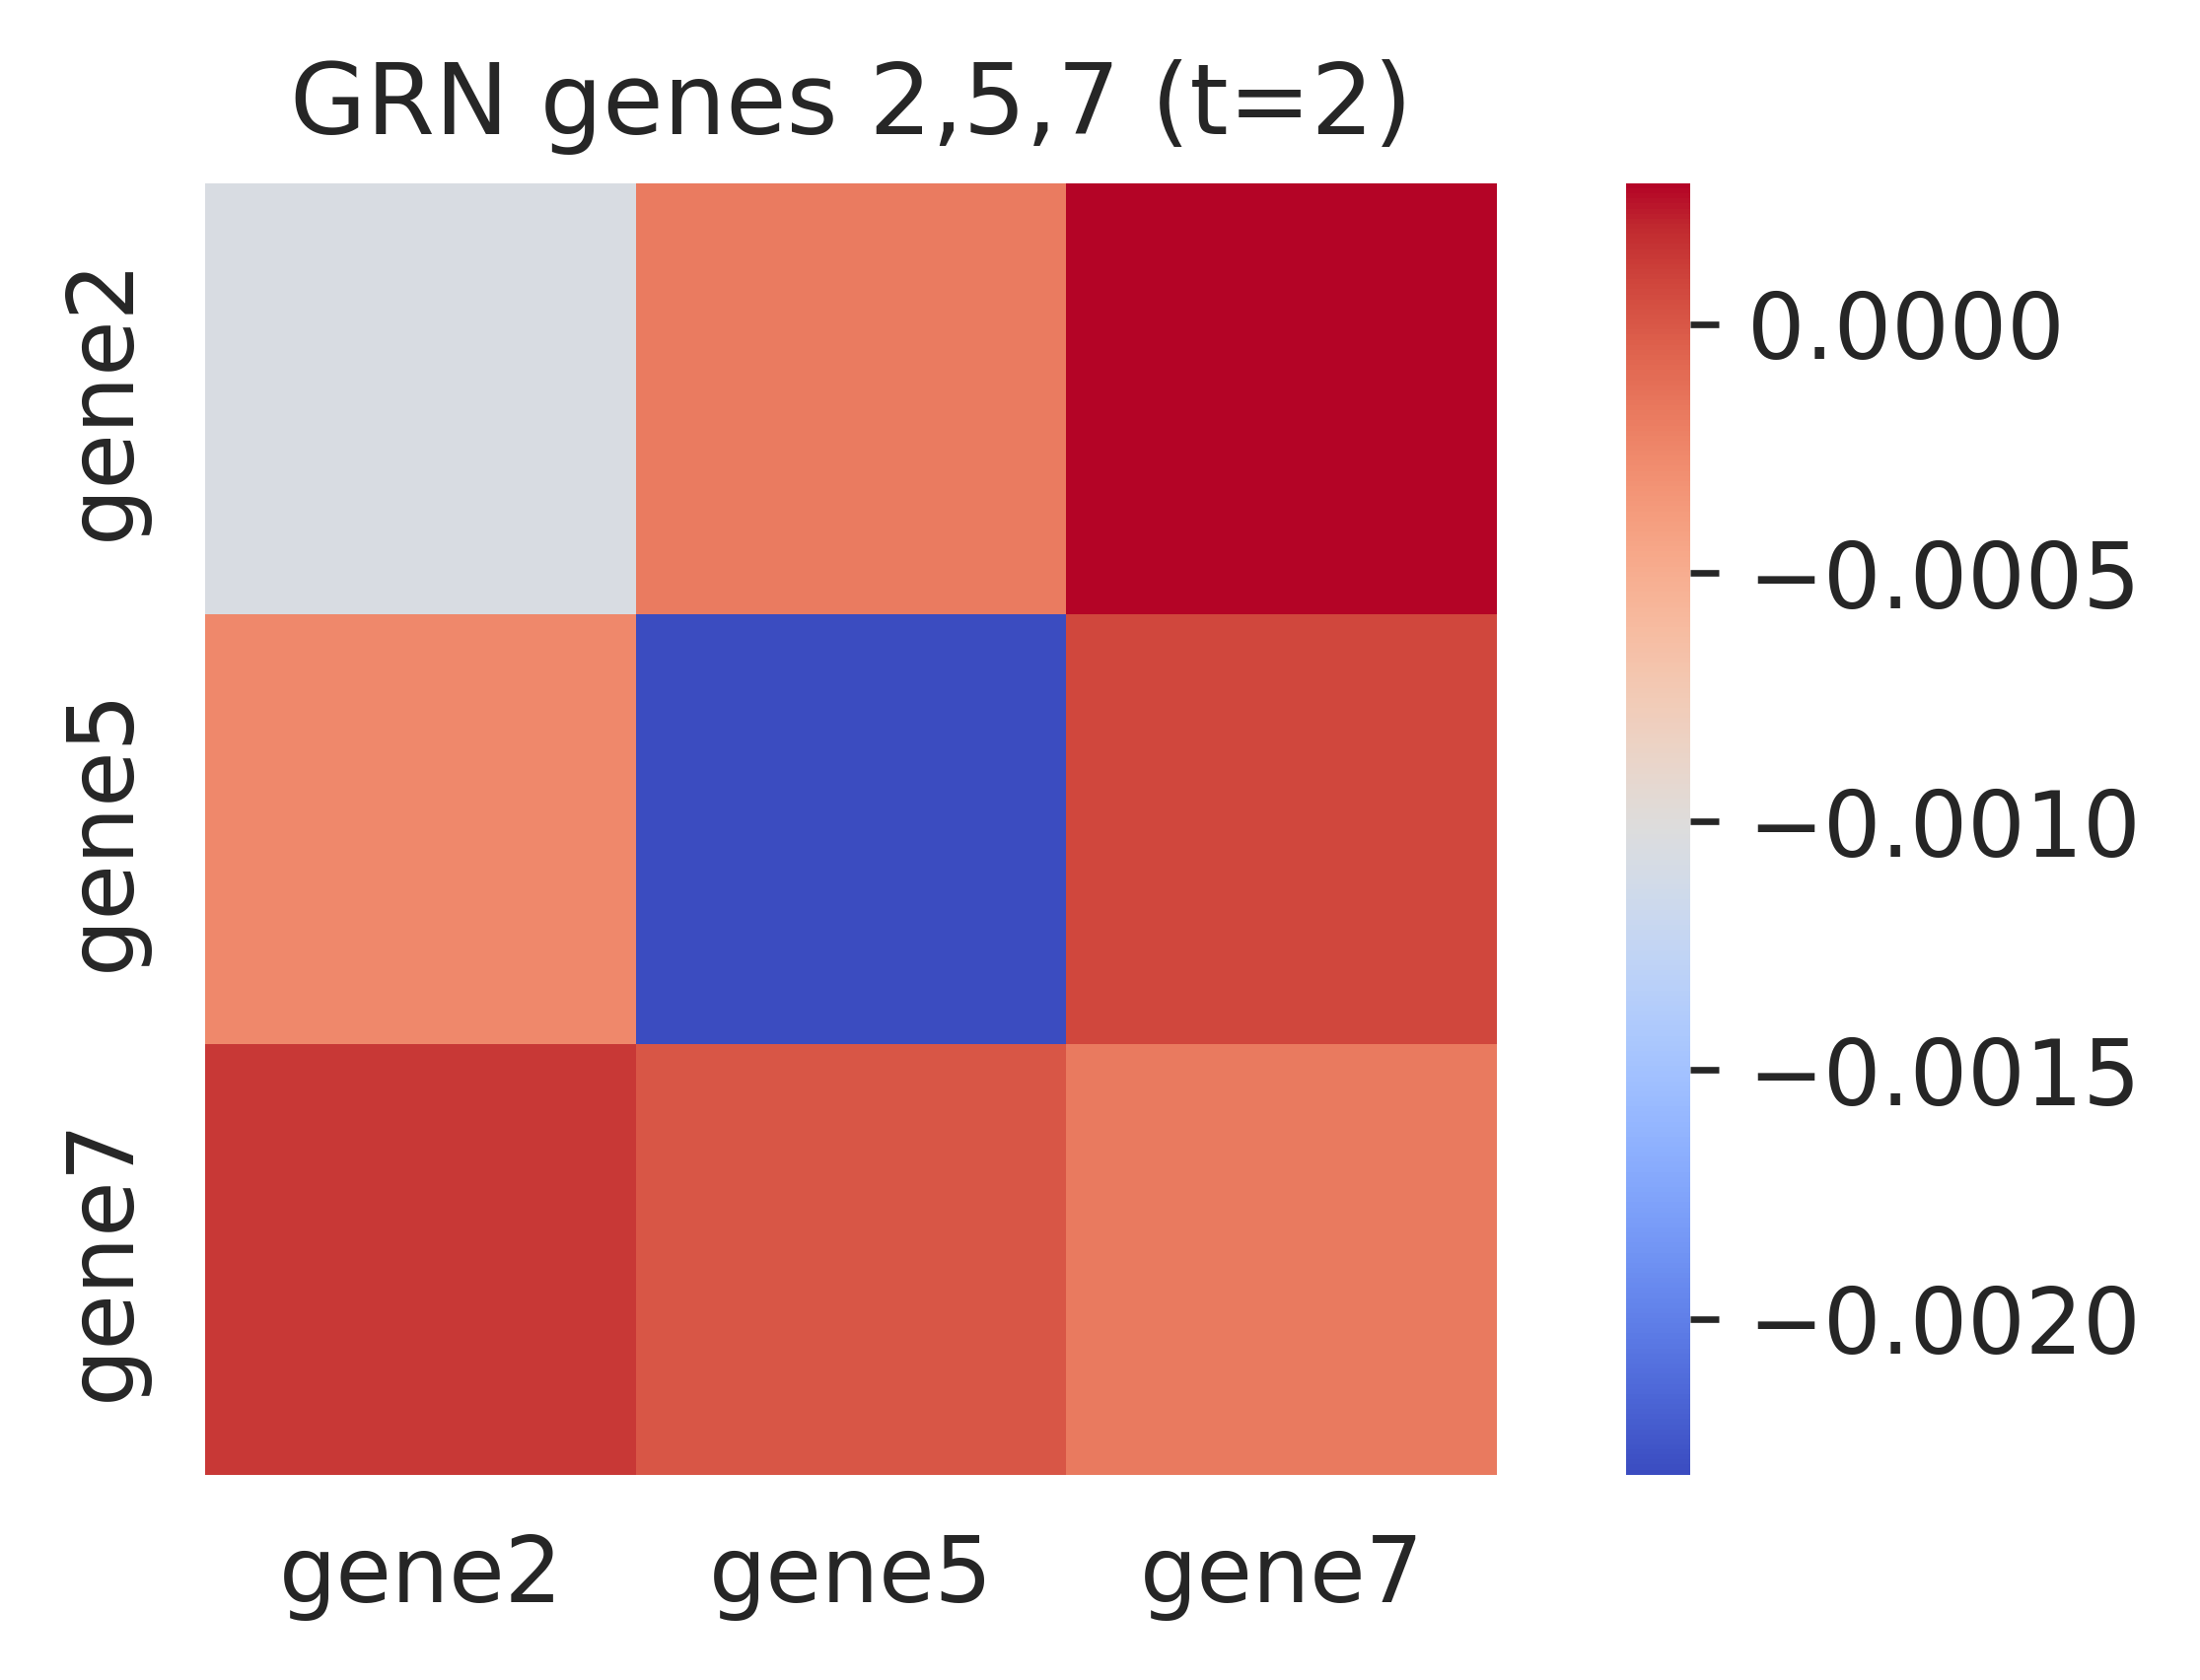

Processing time points: 100%|██████████| 3/3 [00:04<00:00,  1.42s/it]


In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
def run_grn_v_only(f_net, df, dim, output_path, device='cuda',
                   use_gene=False, genes=""):
    """
    Compute the Jacobian using only f_net.v_net, optionally project to gene space and plot selected gene interactions.

    Args:
        f_net          : FNet model with loaded weights
        df             : DataFrame containing 'samples' and x1...xd
        dim            : Data dimension (e.g., 50)
        output_path    : Path to save results
        device         : Device to run on (default 'cuda')
        use_gene       : Whether to project to original gene space
        genes          : Comma-separated gene indices (1-based), e.g. "3,5,7"
    """

    # If gene-level analysis, load PCA components for projection
    if use_gene:
        pca_components = original_data.varm['PCs'].T
        W = pca_components.T.astype(np.float32)   # (G, dim)
        G = W.shape[0]
        print(f"PCA model loaded, number of original genes = {G}")

        # Parse genes
        if not genes.strip():
            raise ValueError("When use_gene=True, the genes parameter must be provided")
        try:
            gene_idx = [int(x.strip()) - 1 for x in genes.split(',')]
        except ValueError:
            raise ValueError("genes must be comma-separated integers")
        if any(i < 0 or i >= G for i in gene_idx):
            raise IndexError("gene indices out of range")
    else:
        gene_idx = []

    f_net = f_net.to(device)

    all_times = df['samples'].values
    all_times_u = np.unique(all_times)
    all_data = df[[f'x{i}' for i in range(1, dim + 1)]].values

    for time_pt in tqdm(all_times_u, desc="Processing time points"):
        mask = all_times == time_pt
        z_np = all_data[mask].astype(np.float32)
        t_np = np.full((z_np.shape[0], 1), time_pt, np.float32)

        z_t = torch.tensor(z_np, device=device, dtype=torch.float32).requires_grad_(True)
        t_t = torch.tensor(t_np, device=device, dtype=torch.float32)

        # Compute velocity field
        v = f_net.v_net(t_t, z_t)

        # Jacobian computation (GPU)
        def jacobian_batch(f, z):
            B, m = f.shape
            _, n = z.shape
            jac = torch.zeros(B, m, n, device=z.device)
            for i in range(m):
                grad = torch.autograd.grad(
                    outputs=f[:, i],
                    inputs=z,
                    grad_outputs=torch.ones_like(f[:, i]),
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0]
                jac[:, i, :] = grad
            return jac

        jac = jacobian_batch(v, z_t).mean(0).detach().cpu().numpy()  # (dim, dim)

        # Save dim x dim Jacobian
        np.savetxt(os.path.join(output_path, f'jac_t{time_pt}.csv'),
                   jac, delimiter=',', fmt='%.6f')

        if use_gene:
            # Project to original gene space
            jac_gene = W @ jac @ W.T          # (G, G)
            np.savetxt(os.path.join(output_path, f'jac_gene_t{time_pt}.csv'),
                       jac_gene, delimiter=',', fmt='%.6f')

            # Select specified genes
            sub_jac = jac_gene[np.ix_(gene_idx, gene_idx)]
            gene_names = [f"gene{i+1}" for i in gene_idx]

            plt.figure(figsize=(max(2, len(gene_idx)) + 2, max(2, len(gene_idx))), dpi=300)
            sns.heatmap(sub_jac, cmap="coolwarm", square=True,
                        xticklabels=gene_names, yticklabels=gene_names)
            plt.title(f'GRN genes {",".join(str(i+1) for i in gene_idx)} (t={time_pt})')
            plt.tight_layout()
            plt.show()
            plt.savefig(os.path.join(output_path,
                                     f'GRN_genes_{",".join(str(i+1) for i in gene_idx)}_t{time_pt}.pdf'),
                        format='pdf', bbox_inches='tight')
            plt.close()
        else:
            # Only plot the top-left 3x3 block
            dim_small = min(3, dim)
            jac_small = jac[:dim_small, :dim_small]
            plt.figure(figsize=(4, 3), dpi=300)
            sns.heatmap(jac_small, cmap="coolwarm", square=True,
                        xticklabels=[f'x{i}' for i in range(1, dim_small + 1)],
                        yticklabels=[f'x{i}' for i in range(1, dim_small + 1)])
            plt.title(f'Jacobian v(t={time_pt})')
            plt.tight_layout()
            plt.show()
            plt.savefig(os.path.join(output_path, f'Average_jac_v_t{time_pt}.pdf'),
                        format='pdf', bbox_inches='tight')
            plt.close()


# run_grn_v_only(f_net, df, dim, exp_dir, device='cuda',
#                    use_gene=False)
run_grn_v_only(f_net, df, dim, exp_dir, device='cuda',
                   use_gene=True, genes="2,5,7")

